In [1]:
import pandas as pd
import glob
import tensorflow as tf
from tensorflow.data import Dataset
from matplotlib import pyplot
from tensorflow.keras.callbacks import TensorBoard
import numpy as np

2021-10-21 12:36:10.325085: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-21 12:36:10.325122: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
df_23043 = pd.read_csv("../data/datasets_by_whale/1999CA-Bmu-23043.csv")[["location-long", "location-lat"]]

In [3]:
def split_data(df):

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):]
    #test_df = df[int(n*0.9):]

    num_features = df.shape[1]
    
    return train_df, val_df#,test_df

In [6]:
train_df,val_df = split_data(df_23043)

In [7]:
def data_windowing(train_df,val_df):
    n_points = 20
    window_length = n_points+ 1 
    
    window_train = tf.keras.utils.timeseries_dataset_from_array(
    train_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
    
    """
    window_test = tf.keras.utils.timeseries_dataset_from_array(
    test_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
    """
        
    window_val = tf.keras.utils.timeseries_dataset_from_array(
    val_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
    
    return window_train, window_val

In [8]:
def data_map(elem):
    n_points = 20
    window_length = n_points+ 1 
    X,y = elem[:,:-1,:],elem[:,-1:,0:2]
    X.set_shape([None, n_points, None])
    y.set_shape([None, window_length - n_points, None])
    
    return (X,y)


In [9]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=2)
])

2021-10-21 12:36:13.609474: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-21 12:36:13.609514: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-21 12:36:13.609530: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-R3AGIN3): /proc/driver/nvidia/version does not exist
2021-10-21 12:36:13.609719: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
lstm_model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=0.0001),metrics=[tf.metrics.MeanAbsoluteError()])

In [11]:
window_train,window_val = data_windowing(train_df,val_df)
train = window_train.map(data_map)
#test = window_test.map(data_map)
val = window_val.map(data_map)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=5,
                                                mode='min')

tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=2)

history = lstm_model.fit(train, epochs=100,
                         validation_data=val,
                         callbacks=[early_stopping, tensorboard_callback])




2021-10-21 12:36:15.031092: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 12:36:15.031135: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 12:36:15.031181: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 12:36:15.053374: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
6/9 [===================>..........] - ETA: 0s - loss: 7861.3047 - mean_absolute_error: 77.7033

2021-10-21 12:36:16.524903: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 12:36:16.524948: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 12:36:16.544371: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 12:36:16.550598: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 12:36:16.582236: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_12_36_16

2021-10-21 12:36:16.598278: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_12_36_16/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 12:36:16.611715: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_12_36_16

2021-10-21 12:36:16.

9/9 [==============================] - 2s 77ms/step - loss: 7952.6509 - mean_absolute_error: 78.2269 - val_loss: 7397.1880 - val_mean_absolute_error: 73.6769
Epoch 2/100
9/9 [==============================] - 0s 18ms/step - loss: 7945.7686 - mean_absolute_error: 78.1801 - val_loss: 7389.3613 - val_mean_absolute_error: 73.6140
Epoch 3/100
9/9 [==============================] - 0s 17ms/step - loss: 7934.5073 - mean_absolute_error: 78.0968 - val_loss: 7381.3076 - val_mean_absolute_error: 73.5507
Epoch 4/100
9/9 [==============================] - 0s 18ms/step - loss: 7926.2192 - mean_absolute_error: 78.0471 - val_loss: 7372.9512 - val_mean_absolute_error: 73.4872
Epoch 5/100
9/9 [==============================] - 0s 17ms/step - loss: 7917.9326 - mean_absolute_error: 77.9903 - val_loss: 7364.2583 - val_mean_absolute_error: 73.4232
Epoch 6/100
9/9 [==============================] - 0s 18ms/step - loss: 7907.2002 - mean_absolute_error: 77.9229 - val_loss: 7355.1714 - val_mean_absolute_error: 

9/9 [==============================] - 0s 21ms/step - loss: 3848.0544 - mean_absolute_error: 55.3107 - val_loss: 3468.0017 - val_mean_absolute_error: 50.6176
Epoch 50/100
9/9 [==============================] - 0s 20ms/step - loss: 3663.0024 - mean_absolute_error: 54.0298 - val_loss: 3246.1567 - val_mean_absolute_error: 48.9938
Epoch 51/100
9/9 [==============================] - 0s 19ms/step - loss: 3420.7546 - mean_absolute_error: 52.3136 - val_loss: 3048.0615 - val_mean_absolute_error: 47.4817
Epoch 52/100
9/9 [==============================] - 0s 19ms/step - loss: 3239.6191 - mean_absolute_error: 50.8967 - val_loss: 2860.7388 - val_mean_absolute_error: 45.9895
Epoch 53/100
9/9 [==============================] - 0s 20ms/step - loss: 3021.1965 - mean_absolute_error: 49.2337 - val_loss: 2673.8679 - val_mean_absolute_error: 44.4378
Epoch 54/100
9/9 [==============================] - 0s 17ms/step - loss: 2813.5095 - mean_absolute_error: 47.4924 - val_loss: 2475.0791 - val_mean_absolute_er

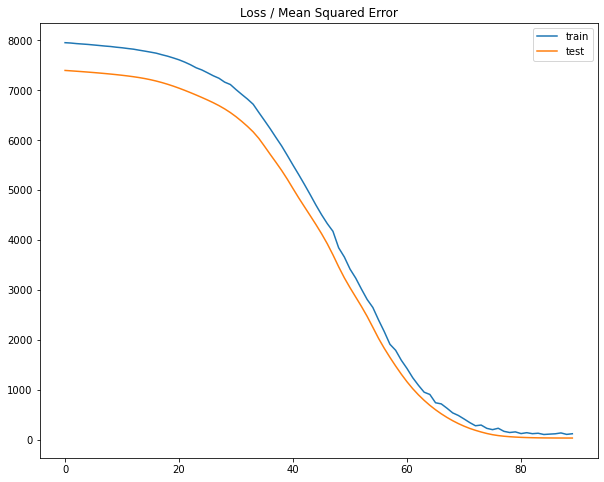

In [12]:
pyplot.figure(figsize=(10,8))
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [13]:
list(val.take(1).as_numpy_iterator())[0][1][0][0]

array([-122.878,   37.589])

In [14]:
np.array([list(val.take(1).as_numpy_iterator())[0][0][0]]).shape

(1, 20, 2)

In [15]:
lstm_model.layers[0].input_shape

(None, 20, 2)

In [16]:
np.array([val_df[:20]])

array([[[-123.14 ,   37.667],
        [-122.513,   37.741],
        [-123.055,   37.716],
        [-123.105,   37.725],
        [-123.265,   37.712],
        [-123.22 ,   37.522],
        [-123.032,   37.607],
        [-123.182,   37.659],
        [-122.89 ,   37.546],
        [-122.928,   37.625],
        [-122.907,   37.781],
        [-123.129,   37.588],
        [-122.951,   37.591],
        [-123.081,   37.509],
        [-123.017,   37.495],
        [-123.08 ,   37.577],
        [-122.968,   37.511],
        [-123.381,   37.576],
        [-122.904,   37.427],
        [-123.132,   37.471]]])

In [17]:
val_df[:21]

,location-long,location-lat
290,-123.140,37.667
291,-122.513,37.741
292,-123.055,37.716
293,-123.105,37.725
294,-123.265,37.712
295,-123.220,37.522
296,-123.032,37.607
297,-123.182,37.659
298,-122.890,37.546
299,-122.928,37.625


In [18]:
y_pred = lstm_model.predict(np.array([val_df[:20]]))[0]

In [19]:
y_pred 

array([-117.97619 ,   33.007256], dtype=float32)

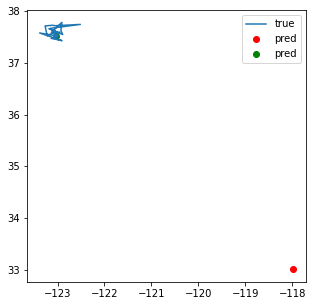

In [23]:
pyplot.figure(figsize=(5,5))
pyplot.plot(val_df[:20]["location-long"], val_df[:20]["location-lat"], label='true')
pyplot.scatter(y_pred[0], y_pred[1],  c="red", label='pred')
pyplot.scatter(val_df.iloc[21][0], val_df.iloc[21][1],  c="green", label='pred')
pyplot.legend()
pyplot.show()

In [24]:
val_df.iloc[21]

location-long   -123.031
location-lat      37.511
Name: 311, dtype: float64

In [25]:
lstm_model.predict(np.array([list(val.take(1).as_numpy_iterator())[0][0][0]]))

array([[-117.97619 ,   33.007256]], dtype=float32)